In [2]:
import os
import json
import requests
from datetime import datetime, timezone, timedelta
from google.cloud import bigquery
from collections import deque
import pandas as pd
import math

os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"
] = "/Users/jeff-901/.config/gcloud/application_default_credentials.json"
client = bigquery.Client("cloud-city-cal")

In [3]:
import json

segment_definition_query_job = client.query(
    f"""
            SELECT data
            FROM `cloud-city-cal.cloud_city.metadata`
            ORDER BY version DESC
            LIMIT 1
            """,
)
result = segment_definition_query_job.result()
segment_definition = next(result)["data"]["segments"]
segment_definition

[{'city': 'Fremont',
  'end_point': [37.45905179732368, -121.92400047999844],
  'end_postmile': 10.782,
  'id': 1,
  'representative_point': [37.45677537, -121.9234573],
  'representative_postmile': 10.634,
  'start_point': [37.45449894221499, -121.92291417547628],
  'start_postmile': 10.432,
  'station_ids': {'401643': 0.34999999999999964}},
 {'city': 'Fremont',
  'end_point': [37.484815553610595, -121.93810388857243],
  'end_postmile': 12.648,
  'id': 2,
  'representative_point': [37.47193368, -121.9310522],
  'representative_postmile': 11.678,
  'start_point': [37.45905179732368, -121.92400047999844],
  'start_postmile': 10.782,
  'station_ids': {'401643': 0.04550000000000054,
   '402789': 0.19950000000000045,
   '402800': 0.3689999999999998,
   '402802': 0.1144999999999996,
   '402828': 0.4989999999999988,
   '407219': 0.38950000000000173,
   '408755': 0.2394999999999996,
   '408756': 0.009499999999999176}},
 {'city': 'Fremont',
  'end_point': [37.49336665307788, -121.9492194403316

In [4]:
START = datetime.strptime("2024/01/01 00:00:00", "%Y/%m/%d %H:%M:%S")
END = datetime.strptime("2024/01/15 00:00:00", "%Y/%m/%d %H:%M:%S")
TIME_STEP = 5 * 60

In [5]:
speed_query_job = client.query(
    f"""
            SELECT station_id, 
                    UNIX_SECONDS(PARSE_TIMESTAMP('%m/%d/%Y %H:%M:%S', time)) + 28800 AS t, 
                    lanes[0].average_speed AS speed
            FROM `cloud-city-cal.cloud_city.pems_partitioned`
            WHERE UNIX_SECONDS(PARSE_TIMESTAMP('%m/%d/%Y %H:%M:%S', time)) >= {int(START.replace(tzinfo=timezone.utc).timestamp())}
            AND UNIX_SECONDS(PARSE_TIMESTAMP('%m/%d/%Y %H:%M:%S', time)) < {int(END.replace(tzinfo=timezone.utc).timestamp())}
            AND publish_time >= {int((START-timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
            AND publish_time <= {int((END + timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
            ORDER BY station_id, t ASC
            """,
)
result = speed_query_job.result()
station_t_to_speed = {}
i = 1
for row in result:
    row = dict(row.items())
    station_t_to_speed[(row["station_id"], row["t"])] = row["speed"]

data = []
for t in range(int(START.timestamp()), int(END.timestamp()), TIME_STEP):
    for segment in segment_definition:
        agg_speed = (segment["end_postmile"] - segment["start_postmile"]) / sum(
            [
                segment["station_ids"][station_id]
                / station_t_to_speed[(int(station_id), t)]
                for station_id in segment["station_ids"]
            ]
        )
        data.append({"segment_id": segment["id"], "t": t, "speed": agg_speed})
speed_df = pd.DataFrame(data)
speed_df

KeyboardInterrupt: 

In [29]:
speed_df.to_csv("speed_preprocessed.csv")

In [15]:
speed_df = pd.read_csv("speed_preprocessed.csv")

In [16]:
cities = {}
for segment in segment_definition:
    if segment["city"] not in cities:
        cities[segment["city"]] = [segment["id"]]
    else:
        cities[segment["city"]].append(segment["id"])
WEATHER_CONDITION = {
    "Thunderstorm": 0,
    "Drizzle": 1,
    "Rain": 2,
    "Snow": 3,
    "Mist": 4,
    "Smoke": 5,
    "Haze": 6,
    "Dust": 7,
    "Fog": 8,
    "Sand": 9,
    "Ash": 10,
    "Squall": 11,
    "Tornado": 12,
    "Clear": 13,
    "Clouds": 14,
}
data = []
for city in cities:
    query_job = client.query(
        f"""
        SELECT dt AS t, weather[0].main, visibility
        FROM `cloud-city-cal.cloud_city.weather_partitioned`
        WHERE name LIKE "{city}"
        AND dt >= {int(START.timestamp())}
        ANd dt <= {int(END.timestamp()) + 60}
        AND publish_time >= {int((START-timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
        AND publish_time <= {int((END + timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
        ORDER BY dt ASC
        """,
    )
    result = query_job.result()
    result = [row for row in result]

    idx = 0
    for t in range(int(START.timestamp()), int(END.timestamp()), TIME_STEP):
        while idx + 1 < len(result) and result[idx + 1][0] <= t + 60:
            idx += 1
        weather_encoding = ["0"] * len(WEATHER_CONDITION)
        weather_encoding[WEATHER_CONDITION[result[idx][1]]] = "1"
        for segment_id in cities[city]:
            data.append([segment_id, t] + weather_encoding + [result[idx][2]])
weather_df = pd.DataFrame(
    data, columns=["segment_id", "t"] + list(WEATHER_CONDITION.keys()) + ["visibility"]
)
weather_df

,segment_id,t,Thunderstorm,Drizzle,Rain,Snow,Mist,Smoke,Haze,Dust,Fog,Sand,Ash,Squall,Tornado,Clear,Clouds,visibility
0,1,1704096000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
1,2,1704096000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
2,3,1704096000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
3,4,1704096000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
4,5,1704096000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68539,17,1705304100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
68540,17,1705304400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
68541,17,1705304700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000
68542,17,1705305000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10000


In [10]:
def coordinate_to_postmile(x: float, y: float) -> float:
    payload = {"callType": "getPostmileForPoint", "content": {"x": x, "y": y}}
    response = requests.post(
        "https://postmile.dot.ca.gov/PMQT/proxy.php",
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
        },
        data="request=" + json.dumps(payload),
    )
    response.raise_for_status()
    data = json.loads(response.text)
    if "locations" not in data:
        print(data, x, y)
    postmile_data = data["locations"][0]["results"][0]["postmile"]
    payload = {
        "callType": "getOdometerForPostmile",
        "content": {
            "req": {
                "routeNumber": postmile_data["routeNumber"],
                "routeSuffixCode": postmile_data["routeSuffix"],
                "countyCode": postmile_data["county"],
                "postmilePrefixCode": postmile_data["postmilePrefix"],
                "postmileSuffixCode": postmile_data["postmileSuffix"],
                "postmileValue": postmile_data["postmileValue"],
                "alignmentCode": "",
            }
        },
    }
    response = requests.post(
        "https://postmile.dot.ca.gov/PMQT/proxy.php",
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
        },
        data="request=" + json.dumps(payload),
    )
    response.raise_for_status()
    return float(response.text)

In [17]:
SEVERITY_TO_SCORE = {"MINOR": 1, "MODERATE": 2, "MAJOR": 3, "SEVERE": 4, "UNKNOWN": 1}
EVENT_TYPE_TO_IDX = {
    "CONSTRUCTION": 0,
    "SPECIAL_EVENT": 1,
    "INCIDENT": 2,
    "WEATHER_CONDITION": 3,
    "ROAD_CONDITION": 4,
    "None": 5,
}
event_query_job = client.query(
    f"""
    SELECT id, 
        event_type, 
        severity, 
        UNIX_SECONDS(PARSE_TIMESTAMP('%Y-%m-%dT%H:%MZ', created)) + 28800 AS created_time, 
        UNIX_SECONDS(PARSE_TIMESTAMP('%Y-%m-%dT%H:%MZ', updated)) + 28800 AS updated_time, 
    geography_point.coordinates[0], geography_point.coordinates[1] 
    FROM cloud-city-cal.cloud_city.bay_area_511_event_partitioned
    WHERE "I-880 N" in UNNEST(roads.name)
    AND UNIX_SECONDS(PARSE_TIMESTAMP('%Y-%m-%dT%H:%MZ', created)) + 28800 >= {int(START.replace(tzinfo=timezone.utc).timestamp()) - 60 * 60}
    AND UNIX_SECONDS(PARSE_TIMESTAMP('%Y-%m-%dT%H:%MZ', created)) + 28800 < {int(END.replace(tzinfo=timezone.utc).timestamp())}
    AND publish_time >= {int((START-timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
    AND publish_time <= {int((END + timedelta(days=1)).replace(tzinfo=timezone.utc).timestamp())*(10**6)}
    ORDER BY created_time ASC, updated_time ASC
    """
)
result = event_query_job.result()
events = []
event_ids = set()
i = 0
import time

for row in result:
    row = dict(row.items())
    if row["id"] in event_ids:
        continue
    event_ids.add(row["id"])
    i += 1
    # row["postmile"] = coordinate_to_postmile(row["f0_"], row["f1_"])
    events.append(row)

events

[{'id': '511.org/1134286',
  'event_type': 'INCIDENT',
  'severity': 'Moderate',
  'created_time': 1704079080,
  'updated_time': 1704079140,
  'f0_': -121.90428924560547,
  'f1_': 37.38211441040039},
 {'id': '511.org/1134291',
  'event_type': 'INCIDENT',
  'severity': 'Moderate',
  'created_time': 1704084540,
  'updated_time': 1704084540,
  'f0_': -121.90946960449219,
  'f1_': 37.355892181396484},
 {'id': '511.org/1134303',
  'event_type': 'INCIDENT',
  'severity': 'Moderate',
  'created_time': 1704088680,
  'updated_time': 1704088740,
  'f0_': -122.1270980834961,
  'f1_': 37.68330383300781},
 {'id': '511.org/1134389',
  'event_type': 'INCIDENT',
  'severity': 'Moderate',
  'created_time': 1704108480,
  'updated_time': 1704108480,
  'f0_': -121.94071197509766,
  'f1_': 37.326690673828125},
 {'id': '511.org/1134404',
  'event_type': 'INCIDENT',
  'severity': 'Moderate',
  'created_time': 1704111060,
  'updated_time': 1704111060,
  'f0_': -122.1280746459961,
  'f1_': 37.68397903442383},


In [19]:
with open("event.json", "r") as f:
    tmp = json.load(f)
    d = {}
    for row in tmp:
        d[row[0]] = row[-1]
    del tmp
    for event in events:
        event["postmile"] = d[event["id"]]
events

deque([{'id': '511.org/1134404',
        'event_type': 'INCIDENT',
        'severity': 'Moderate',
        'created_time': 1704111060,
        'updated_time': 1704111060,
        'f0_': -122.1280746459961,
        'f1_': 37.68397903442383,
        'postmile': 30.27},
       {'id': '511.org/1134427',
        'event_type': 'INCIDENT',
        'severity': 'Moderate',
        'created_time': 1704116160,
        'updated_time': 1704116160,
        'f0_': -122.1270980834961,
        'f1_': 37.68330383300781,
        'postmile': 30.198},
       {'id': '511.org/1134508',
        'event_type': 'INCIDENT',
        'severity': 'Moderate',
        'created_time': 1704150660,
        'updated_time': 1704150660,
        'f0_': -121.93550109863281,
        'f1_': 37.48200225830078,
        'postmile': 12.382},
       {'id': '511.org/1134607',
        'event_type': 'INCIDENT',
        'severity': 'Moderate',
        'created_time': 1704189540,
        'updated_time': 1704189600,
        'f0_': -121.94

In [20]:
events = deque(events)
queue = deque()
data = []
for t in range(int(START.timestamp()), int(END.timestamp()), TIME_STEP):
    while events and events[0]["created_time"] <= t:
        queue.append(events.popleft())
    while queue and queue[0]["created_time"] < t - 60 * 60:
        queue.popleft()
    for segment in segment_definition:
        score = 0
        event_type = 5
        for event in queue:
            if (
                event["postmile"] < segment["representative_postmile"]
                and event["postmile"] >= segment["representative_postmile"] - 10
            ):
                new_score = (
                    SEVERITY_TO_SCORE[event["severity"].upper()]
                    * math.exp(
                        -float(segment["representative_postmile"] - event["postmile"])
                        / 7
                    )
                    * math.exp(-float(t - event["created_time"]) / 600)
                )

                if new_score > score:
                    score = new_score
                    event_type = EVENT_TYPE_TO_IDX[event["event_type"]]
        event_encoding = ["0"] * len(EVENT_TYPE_TO_IDX)
        event_encoding[event_type] = "1"
        data.append([segment["id"], t] + event_encoding + [score])
event_df = pd.DataFrame(
    data, columns=["segment_id", "t"] + list(EVENT_TYPE_TO_IDX.keys()) + ["event_score"]
)
event_df

,segment_id,t,CONSTRUCTION,SPECIAL_EVENT,INCIDENT,WEATHER_CONDITION,ROAD_CONDITION,None,event_score
0,1,1704096000,0,0,0,0,0,1,0.0
1,2,1704096000,0,0,0,0,0,1,0.0
2,3,1704096000,0,0,0,0,0,1,0.0
3,4,1704096000,0,0,0,0,0,1,0.0
4,5,1704096000,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...
68539,13,1705305300,0,0,0,0,0,1,0.0
68540,14,1705305300,0,0,0,0,0,1,0.0
68541,15,1705305300,0,0,0,0,0,1,0.0
68542,16,1705305300,0,0,0,0,0,1,0.0


In [21]:
df = pd.DataFrame()
df = pd.concat((df, speed_df))
df = df.merge(weather_df, on=["segment_id", "t"])
df = df.merge(event_df, on=["segment_id", "t"])
df_cp = df.__deepcopy__()
df

,Unnamed: 0,segment_id,t,speed,Thunderstorm,Drizzle,Rain,Snow,Mist,Smoke,...,Clear,Clouds,visibility,CONSTRUCTION,SPECIAL_EVENT,INCIDENT,WEATHER_CONDITION,ROAD_CONDITION,None,event_score
0,0,1,1704096000,76.500000,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
1,1,2,1704096000,75.105919,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
2,2,3,1704096000,74.800000,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
3,3,4,1704096000,74.800000,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
4,4,5,1704096000,74.800000,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68539,68539,13,1705305300,71.663103,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
68540,68540,14,1705305300,72.252537,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
68541,68541,15,1705305300,67.500198,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0
68542,68542,16,1705305300,72.808780,0,0,0,0,0,0,...,0,1,10000,0,0,0,0,0,1,0.0


In [11]:
df.loc[:, "day"] = df["t"].apply(lambda x: datetime.fromtimestamp(x).weekday())
df.loc[:, "hour"] = df["t"].apply(lambda x: datetime.fromtimestamp(x).hour)
df = pd.get_dummies(df, columns=["hour", "day"], dtype=int)
df = df.sort_values(by="t", ascending=True)
df

,segment_id,t,speed,Thunderstorm,Drizzle,Rain,Snow,Mist,Smoke,Haze,...,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,1,1704096000,76.500000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16,17,1704096000,74.656162,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15,16,1704096000,76.500000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14,15,1704096000,75.263771,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,14,1704096000,72.831002,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68528,2,1705305300,74.889263,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
68527,1,1705305300,76.100000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
68542,16,1705305300,72.808780,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
68534,8,1705305300,72.061583,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [31]:
df.columns

Index(['segment_id', 't', 'speed', 'Thunderstorm', 'Drizzle', 'Rain', 'Snow',
       'Mist', 'Smoke', 'Haze', 'Dust', 'Fog', 'Sand', 'Ash', 'Squall',
       'Tornado', 'Clear', 'Clouds', 'visibility', 'CONSTRUCTION',
       'SPECIAL_EVENT', 'INCIDENT', 'WEATHER_CONDITION', 'ROAD_CONDITION',
       'None', 'event_score'],
      dtype='object')

In [22]:
data = pd.DataFrame()
TIMES = 2  # how many timesteps (5-minute) after the current time
for i in range(len(df["segment_id"].unique())):
    df1 = df[df["segment_id"] == i + 1].copy()
    df1.loc[:, "y"] = df1["speed"].shift(-TIMES)
    df1 = df1.iloc[:-TIMES, :]
    data = pd.concat([data, df1], axis=0)
data[["segment_id", "t", "speed", "y"]].head(10)

,segment_id,t,speed,y
0,1,1704096000,76.5,76.3
17,1,1704096300,76.5,75.9
34,1,1704096600,76.3,77.2
51,1,1704096900,75.9,76.1
68,1,1704097200,77.2,76.0
85,1,1704097500,76.1,75.8
102,1,1704097800,76.0,74.3
119,1,1704098100,75.8,73.7
136,1,1704098400,74.3,74.6
153,1,1704098700,73.7,74.6


In [23]:
from sklearn.model_selection import train_test_split

train_data = data.drop(columns=["segment_id", "t"])
X = train_data.iloc[:, :-1]
Y = train_data["y"]

In [24]:
import numpy as np


def rmse(y, y_predict):
    return np.sqrt(np.mean((y - y_predict) ** 2))

In [25]:
from sklearn.linear_model import LinearRegression as lm

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, shuffle=True)
model = lm()
columns = X_train.columns
model.fit(X_train[columns], y_train)
y_train_predict = model.predict(X_train[columns])
y_test_predict = model.predict(X_test[columns])

print("train rmse:", rmse(y_train, y_train_predict))
print("test rmse:", rmse(y_test, y_test_predict))
print("baseline train rmse:", rmse(X_train["speed"], y_train))
print("baseline test rmse:", rmse(X_test["speed"], y_test))

train rmse: 2.750284673364142
test rmse: 2.7918855674762493
baseline train rmse: 2.774126366843409
baseline test rmse: 2.8177787594760106


In [36]:
model.coef_

array([ 9.65610744e-01, -4.81468299e-14,  3.02162176e-01, -3.90137394e-02,
        4.85722573e-17, -1.26732792e-01,  0.00000000e+00,  1.80227474e-01,
        5.55111512e-17, -7.44727058e-02, -2.77555756e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.13043637e-02, -1.70866048e-01,
        1.13302253e-05,  8.71959281e-02,  0.00000000e+00, -4.19873584e-02,
        0.00000000e+00,  0.00000000e+00, -4.52085697e-02, -8.63940222e-02])

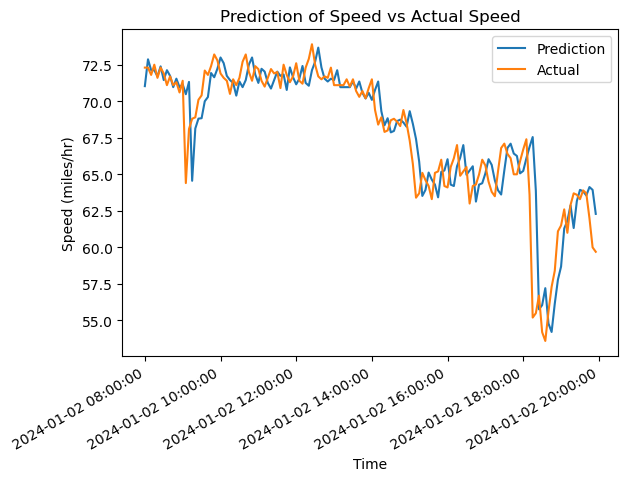

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

draw_data = data[data["segment_id"] == 1].sort_values(by="t", ascending=True)
train_data = draw_data.drop(columns=["segment_id", "t"])
X = train_data.iloc[:, :-1]
Y = train_data["y"]
Y_predict = model.predict(X)
start = datetime(2024, 1, 2, 8, 0, 0, 0)
end = datetime(2024, 1, 2, 20, 0, 0, 0)
idx = (draw_data["t"] >= start.timestamp()) & (draw_data["t"] < end.timestamp())
x_axis = mdates.drange(start, end, timedelta(minutes=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:00:00"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.plot(x_axis, Y_predict[idx], label="Prediction")  # [400:500]
plt.plot(x_axis, Y[idx], label="Actual")  # [400:500]
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Speed (miles/hr)")
plt.title("Prediction of Speed vs Actual Speed")
plt.savefig("Prediction.jpg")
plt.show()

### Nozomu MLP code

In [ ]:
# Category Encoding Function
def categorize_data(X):
    # Categories for bad weather conditions
    bad_weather_conditions = [
        'Thunderstorm', 'Drizzle', 'Rain', 'Snow', 'Mist', 
        'Smoke', 'Haze', 'Dust', 'Fog', 'Sand', 'Ash', 
        'Squall', 'Tornado'
    ]
    X['Bad_Weather'] = X[bad_weather_conditions].any(axis=1).astype(int) 

    # Categories for good weather conditions
    good_weather_conditions = ['Clear', 'Clouds']
    X['Good_Weather'] = X[good_weather_conditions].any(axis=1).astype(int) 

    # Categories for event conditions
    event_conditions = [
        'CONSTRUCTION', 'SPECIAL_EVENT', 'INCIDENT', 
        'WEATHER_CONDITION', 'ROAD_CONDITION', 'None'
    ]
    X['Event_Present'] = X[event_conditions].any(axis=1).astype(int) 

    # Drop the original columns
    X = X.drop(columns=bad_weather_conditions + good_weather_conditions + event_conditions)
    
    return X

# copy the data and categorize it
X_categorized = categorize_data(X.copy())

X_categorized.columns


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

# Numerical features
numerical_features= ["speed", "visibility", "event_score",'speed_5min_ago']

# Constants
N_SPLITS = 5
PCA_COMPONENTS = 33

# Cross-validation with PCA
def cross_validate_model(X, y, numerical_features, kf):
    train_rmse_list = []
    test_rmse_list = []

    for train_index, test_index in kf.split(X):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardization of numerical features data sets
        scaler = StandardScaler()
        X_train_scaled = standardize_features(X_train, numerical_features, scaler)
        X_test_scaled = standardize_features(X_test, numerical_features, scaler, fit=False)

        # PCA application
        X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, PCA_COMPONENTS)

        # Train and evaluate model
        model, train_rmse, test_rmse = train_and_evaluate_model(X_train_pca, X_test_pca, y_train, y_test)

        # Results
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

    return train_rmse_list, test_rmse_list

# Standardize numerical features
def standardize_features(X, numerical_features, scaler, fit=True):
    X_numerical = X[numerical_features]
    X_scaled_numerical = scaler.fit_transform(X_numerical) if fit else scaler.transform(X_numerical)
    X_scaled = pd.concat([pd.DataFrame(X_scaled_numerical, columns=numerical_features, index=X.index),
                          X.drop(columns=numerical_features)], axis=1)
    return X_scaled

# Apply PCA to the data
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# Train and evaluate the model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='sgd',
                         learning_rate='adaptive', alpha=0.0038, max_iter=1000)
    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    train_rmse = rmse(y_train, y_train_predict)
    test_rmse = rmse(y_test, y_test_predict)

    return model, train_rmse, test_rmse

# Load the data
X_categorized = pd.DataFrame(train_data.iloc[:, :-1])  
Y = pd.Series(train_data["y"])  

# Reset the index
X_categorized = X_categorized.reset_index(drop=True)
Y = Y.reset_index(drop=True)

kf = KFold(n_splits=N_SPLITS, shuffle=True)
train_rmse_list, test_rmse_list = cross_validate_model(X_categorized, Y, numerical_features, kf)

print("\n___Average RMSE over 5-Fold Cross-Validation with MLP after PCA___")
print("Average train RMSE:", np.mean(train_rmse_list))
print("Average test RMSE:", np.mean(test_rmse_list))
